In [101]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit
from scipy import signal
import scipy.ndimage as ndimage

from wsxm_read import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
def func_adhesion(force_data, zero_pts):
    f_zero = force_data['approach']['y'][:zero_pts].mean()
    f_min = force_data['retract']['y'].min()
    return f_zero - f_min, {'zero': f_zero, 'min': f_min}

def func_snapin(defl_data):
    defl_sobel = ndimage.sobel(defl_data['approach']['y']) #sobel transform
    idx_min = np.argmin(defl_sobel) #id of sharpest corner in defl data
    defl_snapin = defl_data['approach']['y'][idx_min]
    z_snapin = defl_data['approach']['x'][idx_min]
    defl_idx_min = np.argmin(defl_data['approach']['y'])
    defl_min = defl_data['approach']['y'][defl_idx_min]
    # z_min = defl_data['approach']['x'][defl_idx_min]
    # print(idx_min)
    return defl_snapin - defl_min, {'x': [z_snapin, z_snapin], 'y': [defl_snapin, defl_min]}

def func_stiffness(force_data, bad_pts):
    segment = 'approach'
    idx_min = np.argmin(force_data[segment]['y'])
    if idx_min == force_data[segment]['x'].shape[0]-1: #when spectra not good
        return np.inf, {'x': force_data[segment]['x'][idx_min:], 'y': force_data[segment]['y'][idx_min:]}
    else:
        p, res, rank, sing, rcond = np.polyfit(force_data[segment]['x'][idx_min:], 
                                               force_data[segment]['y'][idx_min:], 1, full=True)
        poly = np.poly1d(p)
        fit_data = {'x': force_data[segment]['x'][idx_min:], 'y': poly(force_data[segment]['x'][idx_min:])}
    return -p[0], fit_data

#TODO: calibration dictionary to get in nm or nN from volts

#dictionary of functions defined to extract spectroscopy data properties
# FUNC_DICT = {'Adhesion': {'function':func_adhesion,
#                           'channel': 'Normal force',
#                           'kwargs': {'zero_pts': 10
#                                     }
#                          },
#              'Stiffness': {'function':func_stiffness,
#                            'channel': 'Normal force',
#                            'kwargs': {'bad_pts':1}
#                            },
#              'Snap-in distance': {'function':func_snapin,
#                                   'channel': 'Normal force',
#                                   'kwargs': {}
#                                   },
#              }

FUNC_DICT = {'Normal force': {'Adhesion': {'function':func_adhesion,
                                           'kwargs': {'zero_pts': 10}
                                           },
                              'Stiffness': {'function':func_stiffness,
                                            'kwargs': {'bad_pts':1}
                                            },
                              'Snap-in distance': {'function':func_snapin,
                                                   'kwargs': {}
                                                   }
                              },
             'Amplitude': {},
             'Excitation frequency': {},
             'Phase': {}
            }

#rename spectroscopy line to standard names: approach and retract
SPECT_DICT = {'Forward':'approach', 'Backward': 'retract'} 

# Get spectroscopy data from force volume
def wsxm_getspectro1(data, channel, img_dir, x, y, segment='both'):
    # label_dict = {'Forward':'approach', 'Backward': 'retract'} #rename lines
    #initialize spectroscopy data dictionary
    data_fd_dict = {'x': np.empty(0), 'y': np.empty(0), 'segment': np.empty(0)}
    #spectroscopy keys for the same image direction
    img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')] 
    spectro_data = {}
    for key in img_keys:
        spectro_dir = SPECT_DICT[key.split(' ')[3]]
        if segment != 'both' and segment != spectro_dir: #skip unwanted segment
            continue
        line_pts = int(data[channel][key]['header']['Number of points per ramp'])
        data_fd_dict['x'] = np.append(data_fd_dict['x'], data[channel][key]['data']['Z'])
        data_fd_dict['y'] = np.append(data_fd_dict['y'], data[channel][key]['data']['ZZ'][:,y,x])
        data_fd_dict['segment'] = np.append(data_fd_dict['segment'], line_pts*[spectro_dir])
        spectro_data[spectro_dir] = {'y': data[channel][key]['data']['ZZ'][:,y,x],
                                     'x': data[channel][key]['data']['Z']}
    data_fd = pd.DataFrame.from_dict(data_fd_dict)
    #perform calculations for parameters (e.g. adhesion, stiffness, check FUNC_DICT) on the single spectroscopy curve
    data_dict_param = {}
    # for param in params:
    #     if channel == FUNC_DICT[param]['channel']:
    #         kwargs = FUNC_DICT[param]['kwargs']
    #         _, data_dict_param[param] = FUNC_DICT[param]['function'](spectro_data, **kwargs)
    for param in FUNC_DICT[channel].keys():
        kwargs = FUNC_DICT[channel][param]['kwargs']
        _, data_dict_param[param] = FUNC_DICT[channel][param]['function'](spectro_data, **kwargs)   
        
    # print(x,y,data['ZZ'])
    return data_fd, data_dict_param

# Get spectroscopy data from separate force-distance measurement (*.curves)
def wsxm_getspectro2(data, channel, curv_num):
    #perform calculations for parameters (e.g. adhesion, stiffness, check FUNC_DICT) on the single spectroscopy curve
    data_fd_dict = data[channel]['Curves'][curv_num]['data']
    data_fd = pd.DataFrame.from_dict(data_fd_dict) #for plotting
    spectro_data = {} #for function analysis
    for t in data_fd['segment'].unique(): #convert dataframe to standard structure of data dictionary for spectroscopy
        spectro_data[t] = {'x': data_fd[data_fd['segment']==t]['x'].to_numpy(),
                           'y': data_fd[data_fd['segment']==t]['y'].to_numpy()}
    data_dict_param = {}
    params = FUNC_DICT[channel].keys()
    for param in params:
        # if channel == FUNC_DICT[param]['channel']:
        kwargs = FUNC_DICT[channel][param]['kwargs']
        _, data_dict_param[param] = FUNC_DICT[channel][param]['function'](spectro_data, **kwargs)
        
    return data_fd, data_dict_param
    
#obtain property image from spectroscopy data of force-volume based on functions defined in FUNC_DICT
def calc_spectro_prop(data, channel, img_dir):
    # img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')] 
    data_dict_spectro = {}
    params = FUNC_DICT[channel].keys()
    for param in params:
        data_dict_spectro[param] = np.empty(0)
    #get common data from first channel e.g. number of points
    # channel = FUNC_DICT[params[0]]['channel']
    key = list(data[channel].keys())[0]
    x_pts = int(data[channel][key]['header']['Number of rows'])
    y_pts = int(data[channel][key]['header']['Number of columns'])
    for y in range(y_pts):
        for x in range(x_pts):
            for param in params:
                # channel = FUNC_DICT[channel][param]['channel']
                kwargs = FUNC_DICT[channel][param]['kwargs']
                img_keys = [key for key in data[channel].keys() if key.startswith(f'Image {img_dir}')]
                spectro_data = {}
                for key in img_keys:
                    spectro_dir = SPECT_DICT[key.split(' ')[3]]
                    spectro_data[spectro_dir] = {'y': data[channel][key]['data']['ZZ'][:,y,x],
                                                 'x': data[channel][key]['data']['Z']}
                param_result,_ = FUNC_DICT[channel][param]['function'](spectro_data, **kwargs)
                data_dict_spectro[param] = np.append(data_dict_spectro[param], [param_result])
    # data_dict_spectro[spectro_dir] = adh_data.reshape(x_pts,y_pts)
        
    return data_dict_spectro


dict_keys(['Normal force', 'Amplitude', 'Excitation frequency', 'Phase'])


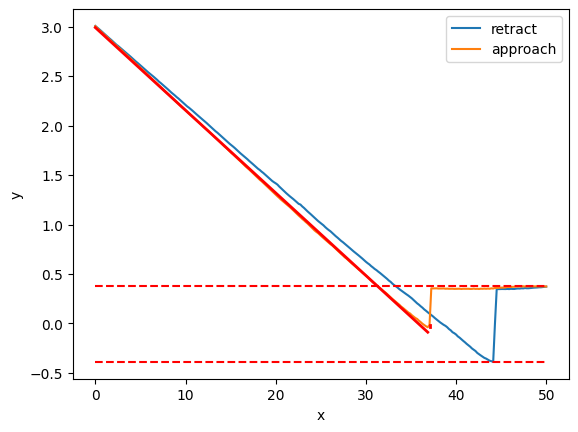

x              50.0
y          3.006893
segment     retract
dtype: object


In [170]:
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'
filepath = 'data/interdigThiolsHeated_tipNweSi3nN_a_0031_Excitation frequency.f.stp'
test_data = wsxm_readstp(filepath)
print(test_data.keys())
test_chan = 'Normal force' #'Normal force', 'Amplitude', 'Excitation frequency', 'Phase'
# print(test_data[test_chan]['Curves'][1]['data'].keys())
test_spectro, test_param = wsxm_getspectro2(test_data, test_chan, 1)
# print(test_param)
fig, ax = plt.subplots()
sns.lineplot(data=test_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title
#show calculations in plot for checking
plt.hlines(test_param['Adhesion']['zero'], test_spectro['x'].min(), 
           test_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(test_param['Adhesion']['min'], test_spectro['x'].min(), 
           test_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(test_param['Snap-in distance']['x'], test_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(test_param['Stiffness']['x'], test_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)

plt.show()
# test_data[test_chan]['Curves'][1]['data']['segment']
print(test_spectro.max())

['data/interdigThiols_tipSi3nN_b_0030.b.dy.top', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch1', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch12', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch15', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch15', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.ch12', 'data/interdigThiols_tipSi3nN_b_0030.b.dy.ch1', 'data/interdigThiols_tipSi3nN_b_0030.f.dy.top']


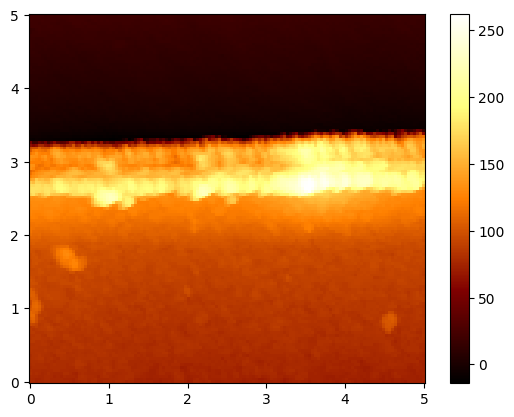

-14.062525423728813 262.5004745762712


In [66]:
filepath = 'data/interdigThiols_tipSi3nN_b_0030.b.dy.top'
test_data = wsxm_readchan(filepath)
test_chan = 'Topography'#'Topography', 'Normal force', 'Excitation frequency', 'Amplitude'
test_dir = 'Backward'
im_data_test = test_data[test_chan][test_dir]['data']
xx = im_data_test['X'].reshape(128,128)
yy = im_data_test['Y'].reshape(128,128)
zz = im_data_test['Z'].reshape(128,128)
plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()
plt.show()
print(zz.min(), zz.max())
# test_data[test_chan][test_dir]['header']

In [25]:
#Load WSxM file
#filepath = 'data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15'
#filepath = 'data/interdigThiols_tipSi3nN_b_0026.f.dy.top'
filepath = 'data/interdigThiols_tipSi3nN_b_0026.fb.ch1.gsi' #ff,fb,bb,bf:1st letter=x dir,2nd letter=z dir
#filepath = 'data/interdigThiols_tipSi3nN_b_0023_Excitation frequency.f.curves'

data_dict = wsxm_readforcevol(filepath) #complete force volume data with all channels

-0.055847207999999995 -0.0076294 0.048217807999999994


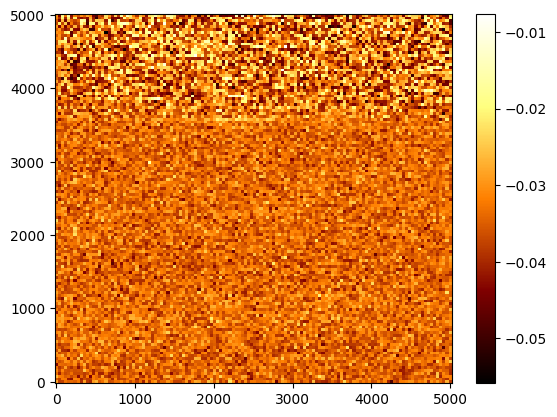

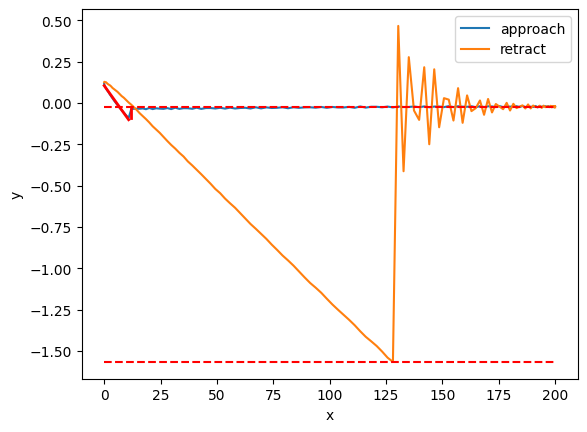

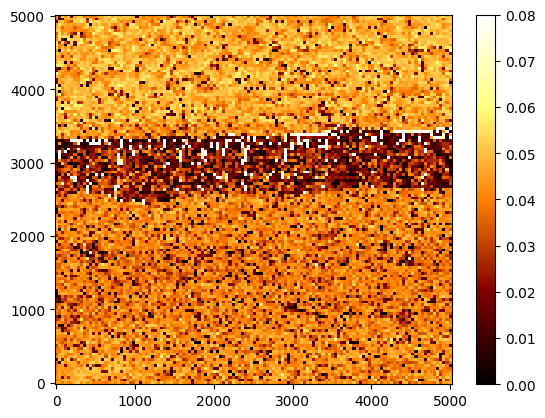

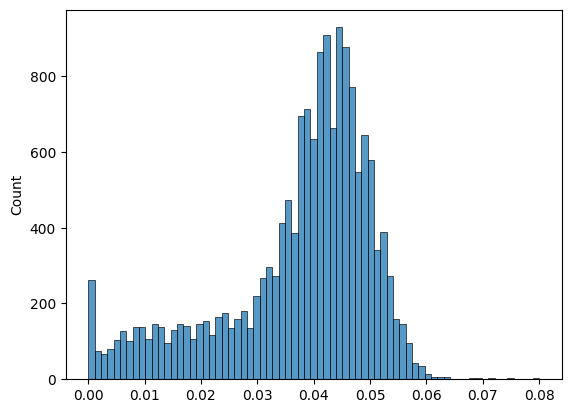

In [80]:
channel = 'Amplitude' #'Excitation frequency', 'Normal force', 'Amplitude', 'Topography'
chan_dir = 'Image Forward with Forward Ramps' #'Image Forward with Forward Ramps', 'Image Backward with Backward Ramps', 'Image Backward with Forward Ramps', 'Image Forward with Backward Ramps'
img_dir = chan_dir.split(' ')[1]
data_dict_chan = data_dict[channel][chan_dir]
im_data = data_dict_chan['data']
header_dict = data_dict_chan['header']
pt_x, pt_y, pt_z = 1, 120, 0

# test_data = wsxm_readcurves(filepath)
#plot AFM Z image
# im_data = test_data['Channel']['data']
xx = im_data['X'].reshape(128,128)
yy = im_data['Y'].reshape(128,128)
# zz = im_data['Z'].reshape(128,128)
zz = im_data['ZZ'][pt_z,:,:]#1st index:xy sections, 2nd index:xz sections, 3rd index: yz sections

#TODO: change and check how forward backward in z (or x) can be consistently plotted
print(zz.min(),zz.max(), zz.max()-zz.min())

plt.pcolormesh(xx,yy,zz, cmap='afmhot')
plt.colorbar()

# if header_dict['Spectroscopy direction'] == 'Forward': #CHECK THIS
#     segment
#obtain and plot spectroscopy data
chan_spectro = 'Normal force'
# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
#CHECK x and y in all functions!!!
data_spectro, data_param = wsxm_getspectro1(data_dict, channel=chan_spectro, img_dir=img_dir,
                                            x=pt_x, y=pt_y, segment='both')
# print(fd)
fig, ax = plt.subplots()
sns.lineplot(data=data_spectro, x="x", y="y", hue="segment", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels) #remove legend title

#show calculations in plot for checking
plt.hlines(data_param['Adhesion']['zero'], data_spectro['x'].min(), 
           data_spectro['x'].max(), linestyles='dashed', colors='r')
plt.hlines(data_param['Adhesion']['min'], data_spectro['x'].min(), 
           data_spectro['x'].max(), linestyles='dashed', colors='r')
plt.plot(data_param['Snap-in distance']['x'], data_param['Snap-in distance']['y'],
         'r', linestyle='solid',linewidth=2)
plt.plot(data_param['Stiffness']['x'], data_param['Stiffness']['y'],
         'r', linestyle='solid',linewidth=2)
# acq_pt = test_data['Curves'][3]['header']['Acquisition point'].strip('()').split(',')
# plt.scatter(float(acq_pt[0]), float(acq_pt[1]),color = 'green')
plt.show()
# header_dict
# #plot Curves
# test_df = pd.DataFrame.from_dict(test_data['Curves'][3]['data'])
# sns.lineplot(data=test_df, x="Z", y="Excitation frequency", hue="Segment")
# plt.show()

# spec_params = ['Adhesion', 'Snap-in distance', 'Stiffness'] #check keys of FUNC_DICT
img_specparams = calc_spectro_prop(data_dict, chan_spectro, img_dir)
img_adh = img_specparams['Snap-in distance']
plt.pcolormesh(xx,yy,img_adh.reshape(128,128), cmap='afmhot',vmin=None, vmax=0.08)
plt.colorbar()
#plot histogram of parameter
plt.figure()
sns.histplot(img_adh,binrange=(0,0.08))
plt.show()
# header_dict

In [98]:
xx[:][10]

array([5000.        , 4960.62992126, 4921.25984252, 4881.88976378,
       4842.51968504, 4803.1496063 , 4763.77952756, 4724.40944882,
       4685.03937008, 4645.66929134, 4606.2992126 , 4566.92913386,
       4527.55905512, 4488.18897638, 4448.81889764, 4409.4488189 ,
       4370.07874016, 4330.70866142, 4291.33858268, 4251.96850394,
       4212.5984252 , 4173.22834646, 4133.85826772, 4094.48818898,
       4055.11811024, 4015.7480315 , 3976.37795276, 3937.00787402,
       3897.63779528, 3858.26771654, 3818.8976378 , 3779.52755906,
       3740.15748031, 3700.78740157, 3661.41732283, 3622.04724409,
       3582.67716535, 3543.30708661, 3503.93700787, 3464.56692913,
       3425.19685039, 3385.82677165, 3346.45669291, 3307.08661417,
       3267.71653543, 3228.34645669, 3188.97637795, 3149.60629921,
       3110.23622047, 3070.86614173, 3031.49606299, 2992.12598425,
       2952.75590551, 2913.38582677, 2874.01574803, 2834.64566929,
       2795.27559055, 2755.90551181, 2716.53543307, 2677.16535

In [121]:
def get_psd(filepath):
    im_data, head_data = read_wsxm_chan(filepath)
    print(head_data)
    #plot AFM Z image
    xx = im_data['X'].reshape(128,128)
    yy = im_data['Y'].reshape(128,128)
    zz = im_data['Z'].reshape(128,128)
    plt.pcolormesh(xx,yy,zz, cmap='afmhot')
    plt.colorbar()
    plt.show()
    
    #Obtain Power Spectral Density of data
    #sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
    sample_rate = float(head_data['Sampling frequency'].split(' ')[0])
    freq_array, z_pow = signal.periodogram(zz, sample_rate, scaling='density') #power spectral density
    z_pow_avg = np.average(z_pow, axis=0) #averaged
    freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
    freq_array_shifted = freq_array + freq_drive
    # plt.plot(freq_array, z_pow_avg)
    # plt.show()

    z = im_data['Z']
    z_rms = np.sqrt(z.dot(z)/z.size)
    
    return freq_array_shifted, z_pow_avg, z_rms


#Lorentzian fit
# y0 = white noise offset, f0 = resonance freq, w = Full width at half maximum, A = area
def lorentzian(f, y0,f0, w, A):
    return y0 + ((2*A/np.pi) * (w / ( w**2 + 4*( f - f0 )**2)))

{'Image header size': '3031', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

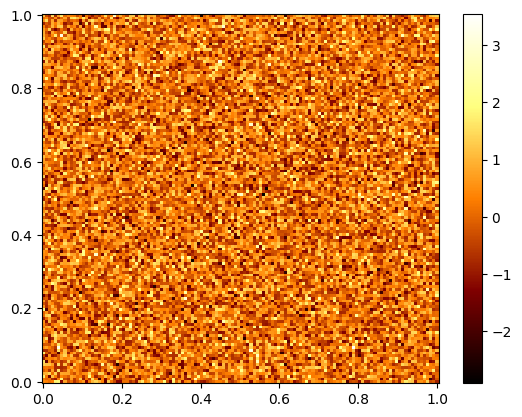

{'Image header size': '3037', 'Angle': '0', 'Set Point': '-9 V', 'Signal Gain': '1', 'Topography Bias': '0 mV', 'X Amplitude': '1 nm', 'X Offset': '0 nm', 'X-Frequency': '58.594 Hz', 'XY Gain': '0.0588235', 'Y Amplitude': '1 nm', 'Y Offset': '-451.813 nm', 'Z Gain': '10', 'Z Offset': '0 nm', 'Amplitude': '1e-006 V', 'Bandwidth': '445.626', 'Filter Out': '8079 Hz', 'Frq. Scan Sensitivity': '0.024 kHz/V', 'Gain in': '100', 'Gain out X': '2', 'Gain out Y': '2', 'Phase': '52.9998 Deg', 'Quality factor (Q)': '171.177', 'Resonance frequency': '72293.6 Hz', 'Input channel': 'Amplitude', 'Integral': '2.5', 'Proportional': '10', 'Tilt X': '0 nm/nm', 'Tilt Y': '0 nm/nm', 'Acquisition channel': 'Amplitude', 'Acquisition primary channel': 'Channel 15', 'Channel is inverted': 'No', 'Conversion Factor 00': '10 nm', 'Conversion Offset 00': '0 nm', 'Force constant': '165.73 N/m', 'Head type': 'AFM', 'Image Data Type': 'short', 'Number of columns': '128', 'Number of rows': '128', 'Round percent': '10',

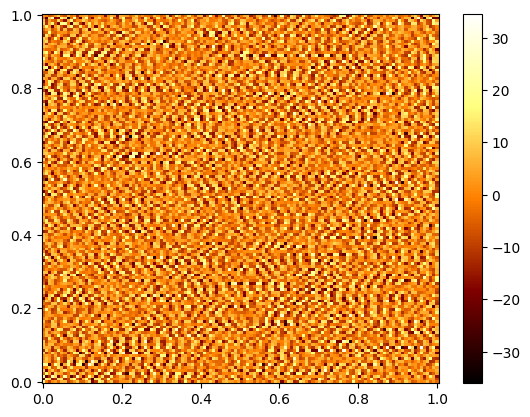

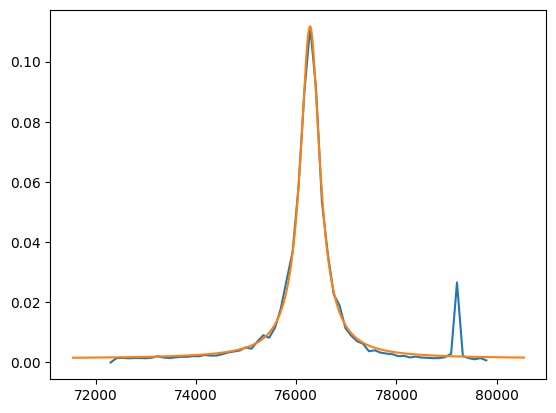

{'offset': 0.0012934139192533319, 'resonance freq': 76274.15433510602, 'fwhm': 473.8767061692985, 'area': 82.11451304229297, 'Q factor': 160.9578047245397}


In [2]:
files = ['data/20240202_laser_off_128pts_58lps_0002.f.dy.ch15', 
         'data/20240202_laser_on_128pts_58lps_0003.f.dy.ch15']
data_dict = {}
rms_min = np.inf
for file in files:
    data_dict[file] = {}
    data_dict[file]['Frequency'], data_dict[file]['PSD'], data_dict[file]['Z rms'] = get_psd(file)
    if data_dict[file]['Z rms'] < rms_min:
        rms_min = data_dict[file]['Z rms']
        off_file = file

on_file = [n for n in files if n != off_file][0]
data_dict[off_file]['Label'] = 'Laser ON'
data_dict[on_file]['Label'] = 'Laser OFF'

#plot data images
# for file in files:
#     plt.plot(data_dict[file]['Frequency'], data_dict[file]['PSD'], label = data_dict[file]['PSD'])
# plt.show()
    

#z_pow = 2*(z_fftx_avg[64:]**2)/(15000*128)
#freq_drive = float(head_data['Resonance frequency'].split(' ')[0])
#freq_array_real = freq_array_shift[64:] + freq_drive
freq_final = data_dict[on_file]['Frequency']
psd_final = data_dict[on_file]['PSD'] - data_dict[off_file]['PSD']
plt.plot(freq_final, psd_final)
#plt.show()

#guess = [0, 76000, 2000, 100000]
y_guess = psd_final.min()
f_guess = freq_final[psd_final.argmax()]
w_guess = 2*np.abs(freq_final[(np.abs(psd_final - psd_final.max()/2)).argmin()]-f_guess)
A_guess = np.pi*w_guess*psd_final.max()/2
guess = [y_guess, f_guess, w_guess, A_guess] #y0,f0,w,A
#fit
popt, pcov = curve_fit(lorentzian, freq_final,psd_final,
                    p0=guess, bounds=(0,np.inf))
#print(np.linalg.cond(pcov))
params = ['offset','resonance freq', 'fwhm', 'area']
fit_dict = dict(zip(params, popt))
fit_dict['Q factor'] = fit_dict['resonance freq']/fit_dict['fwhm']

#plot fit
f_min, f_max = freq_final.min(), freq_final.max()
f_ext = 0.1*(f_max-f_min)
freq_fit_range = np.linspace(f_min-f_ext, f_max+f_ext, 100000)
plt.plot(freq_fit_range,lorentzian(freq_fit_range, *popt))
plt.show()

print(fit_dict)

In [37]:
# Q = head_data['Quality factor (Q)']
k_cant = 2 # N/m
T = 300 #K
kb = 1.380649e-23 #J/K
V_rms = np.sqrt(fit_dict['area'])
corr_fac = 4/3 #Butt-Jaschke correction for thermal noise
sens = np.sqrt(corr_fac*kb*T/k_cant)/V_rms/1e-9 #nm/V 
print(V_rms, sens)
print(np.sqrt(data_dict[on_file]['Z rms']**2 - data_dict[off_file]['Z rms']**2))
# z = im_data['Z']
# print(np.sqrt(z.dot(z)/z.size))

9.061705857193388 0.005798914136715741
9.421556156513725


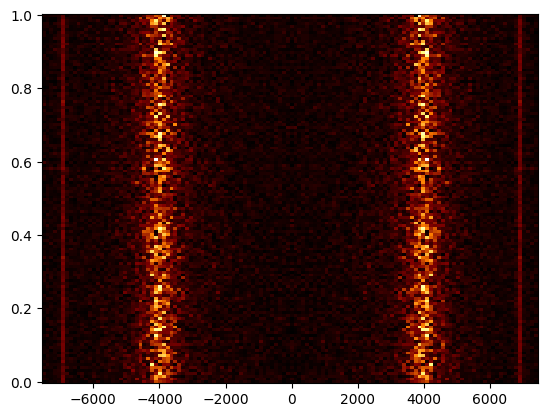

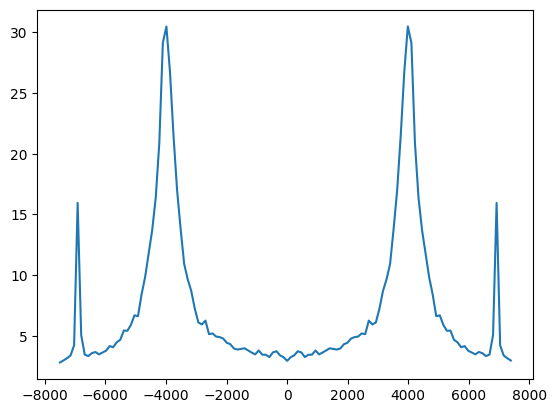

In [6]:
# #1D Fourier Transform of image and average along Y axis.
# z_fftx = np.abs(np.fft.fft(zz))
# z_fftx_shift = np.fft.fftshift(z_fftx)
# z_fftx_avg = np.average(z_fftx_shift, axis=0)

# num_pts = len(z_fftx_avg)
# sample_rate = 2*num_pts*float(head_data['X-Frequency'].split(' ')[0])
# freq_array = np.fft.fftfreq(len(z_fftx_avg), 1 / sample_rate)
# freq_array_shift = np.fft.fftshift(freq_array)
# ff, _ = np.meshgrid(freq_array_shift, freq_array_shift)
# plt.pcolormesh(ff, yy, z_fftx_shift, cmap='afmhot')
# plt.show()
# plt.plot(freq_array_shift, z_fftx_avg)
# plt.show()